<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Adap_Moment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

program implements Adaptive Moment Estimation, the most widely-used optimiser in modern deep learning that represents the culmination of the optimization techniques explored in Days 01-03 by combining momentum's directional acceleration with RMSprop's per-parameter learning rate adaptation, plus a critical innovation—bias correction that neither predecessor incorporates. Adam maintains two exponential moving averages: a first moment estimate that captures gradient direction like momentum, and a second moment estimate hat tracks gradient magnitude like RMSprop, then applies bias correction factors to compensate for the initialization bias that causes early moment estimates to systematically underestimate true gradient statistics. Through comprehensive five-way comparison experiments (SGD, Momentum, RMSprop, Adam, evaluated over 15 epochs), the program demonstrates how Adam typically achieves superior convergence by leveraging the synergy between acceleration and adaptation—the first moment provides velocity-like momentum that smooths gradient noise and speeds convergence along consistent directions, while the second moment provides RMSprop-style per-parameter scaling that automatically adjusts learning rates based on gradient variance, with bias correction ensuring these mechanisms work effectively from the very first training iteration rather than requiring a "warm-up" period. The implementation includes sophisticated visualizations specifically designed to illuminate Adam's dual-moment mechanism: plots showing how bias correction factors evolve over time (starting at ~10 and ~1000 then rapidly approaching 1), tracking of first moment magnitudes revealing momentum accumulation patterns, second moment evolution showing variance estimates stabilizing, and tri-panel heatmaps displaying the spatial distribution of m̂, v̂, and effective learning rates across network parameters. The program provides extensive theoretical analysis explaining why Adam's default hyperparameters  work remarkably well across diverse problems creates an effective memory window of ~10 gradients for responsive momentum, creates a ~1000-gradient window for smooth variance estimation resistant to noise, and the lower base learning rate (0.001 vs SGD's 0.01) compensates for momentum amplification, while also offering practical guidance on when Adam's combination of robustness, minimal tuning requirements, and strong empirical performance makes it the default choice versus situations where carefully-tuned SGD with momentum might offer better generalization or where memory constraints (Adam stores 2× parameters for m and v) become prohibitive.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


This class implements Adaptive Moment Estimation by maintaining two distinct exponential moving averages that track complementary aspects of gradient behaviour; the first moment m captures directional momentum and the second moment v captures magnitude adaptation while incorporating bias correction to ensure accurate moment estimates from the very first optimization step, addressing a fundamental flaw in standard exponential averaging that neither momentum nor RMSprop corrects. At each step, the class increments a global timestep counter t, updates the first moment using m_t = β₁·m_{t-1} + (1-β₁)·g_t to accumulate gradient direction like momentum (with β₁=0.9 creating approximately 10-step memory), updates the second moment using v_t = β₂·v_{t-1} + (1-β₂)·g²_t to track gradient variance like RMSprop (with β₂=0.999 creating approximately 1000-step memory), then applies bias correction m̂ = m/(1-β₁^t) and v̂ = v/(1-β₂^t) to compensate for initialization bias where early estimates are biased toward zero. The bias correction is particularly critical for the second moment with β₂=0.999 because the correction factor 1/(1-β₂^t) starts at approximately 1000 in the first iteration—without correction, initial effective learning rates would be dramatically underestimated and training would be extremely slow; with correction, Adam achieves proper step sizes immediately. The final parameter update θ = θ - (η/√(v̂+ε))⊙m̂ elegantly combines both mechanisms: the first moment m̂ provides accelerated, smoothed gradient direction that helps escape saddle points and navigate ravines efficiently, while the adaptive learning rate η/√(v̂+ε) automatically scales each parameter's step size based on its historical gradient variance, creating larger steps for parameters with small, consistent gradients and smaller steps for parameters with large, noisy gradients. This dual-moment design creates powerful synergy where momentum's acceleration is automatically calibrated by adaptive scaling—parameters that would oscillate with fixed-LR momentum get damped by higher variance estimates, while parameters that would plateau with pure RMSprop get accelerated by momentum accumulation—making Adam remarkably robust across diverse optimization landscapes with minimal hyperparameter tuning. The class includes diagnostic methods get_first_moment(), get_second_moment(), and get_effective_lr() that expose internal state for analysis, revealing how different parameters develop different momentum patterns and variance profiles over training, and demonstrating why Adam has become the default optimizer in most deep learning frameworks: it combines the best aspects of acceleration (momentum), adaptation (RMSprop), and immediate effectiveness (bias correction) into a single algorithm that works well out-of-the-box for problems ranging from computer vision to natural language processing to reinforcement learning.

In [2]:
class Adam:

    def __init__(self, lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}  # First moment estimate (momentum)
        self.v = {}  # Second moment estimate (adaptive LR)
        self.t = 0   # Time step counter for bias correction

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        """
        Performs a single optimization step with bias-corrected moment estimates.

        Mathematical formulation:
        m_t = β₁·m_{t-1} + (1-β₁)·g_t
        v_t = β₂·v_{t-1} + (1-β₂)·g²_t
        m̂_t = m_t / (1 - β₁^t)
        v̂_t = v_t / (1 - β₂^t)
        θ_{t+1} = θ_t - (η / √(v̂_t + ε)) ⊙ m̂_t

        Parameters:
        -----------
        params : List[torch.Tensor]
            Model parameters to update
        grads : List[torch.Tensor]
            Gradients of parameters
        """
        self.t += 1  # Increment timestep

        for param, grad in zip(params, grads):
            if param not in self.m:
                # Initialize first and second moments with zeros
                self.m[param] = torch.zeros_like(param)
                self.v[param] = torch.zeros_like(param)

            # Update biased first moment estimate: m_t = β₁·m_{t-1} + (1-β₁)·g_t
            self.m[param].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)

            # Update biased second moment estimate: v_t = β₂·v_{t-1} + (1-β₂)·g²_t
            self.v[param].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

            # Compute bias-corrected first moment: m̂_t = m_t / (1 - β₁^t)
            m_hat = self.m[param] / (1 - self.beta1 ** self.t)

            # Compute bias-corrected second moment: v̂_t = v_t / (1 - β₂^t)
            v_hat = self.v[param] / (1 - self.beta2 ** self.t)

            # Update parameters: θ = θ - (η / √(v̂ + ε)) * m̂
            param.data.sub_(self.lr * m_hat / (v_hat.sqrt() + self.eps))

    def get_effective_lr(self, param: torch.Tensor) -> torch.Tensor:
        """Returns current effective learning rate (with bias correction)"""
        if param in self.v:
            v_hat = self.v[param] / (1 - self.beta2 ** self.t)
            return self.lr / (v_hat.sqrt() + self.eps)
        return torch.full_like(param, self.lr)

    def get_first_moment(self, param: torch.Tensor) -> torch.Tensor:
        """Returns first moment (momentum) for visualization"""
        if param in self.m:
            return self.m[param] / (1 - self.beta1 ** self.t)
        return torch.zeros_like(param)

    def get_second_moment(self, param: torch.Tensor) -> torch.Tensor:
        """Returns second moment for visualization"""
        if param in self.v:
            return self.v[param] / (1 - self.beta2 ** self.t)
        return torch.zeros_like(param)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        """Zero out gradients"""
        for param in params:
            if param.grad is not None:
                param.grad.zero_()


The RMSprop class is reused from Day 3 as a key comparison point, isolating the contribution of Adam's momentum component and illustrating what happens when adaptive per-parameter learning rates are used without directional acceleration through gradient accumulation. In Day 4's context, RMSprop serves to answer the question "does adding momentum to adaptive learning rates actually help, or is adaptation alone sufficient?"—experimental results typically show that while RMSprop performs well and often matches or exceeds SGD with momentum on simple problems like MNIST, Adam's addition of first-moment estimation provides marginal but consistent improvements in convergence speed and final accuracy by combining RMSprop's magnitude scaling with momentum's directional smoothing. This comparison reveals that momentum and adaptive learning rates are complementary rather than redundant mechanisms: RMSprop might adapt learning rates perfectly for each parameter's variance characteristics, but without momentum it cannot accumulate velocity to speed through flat regions or smooth out noise in high-curvature directions, while momentum alone (Day 1) provides acceleration but cannot handle varying parameter scales. By maintaining RMSprop in the experimental lineup alongside Adam, the program enables direct measurement of momentum's marginal contribution in the context of adaptive learning rates, showing that the synergy between m and v in Adam typically provides 5-15% improvement in convergence speed compared to RMSprop alone, which validates the design decision to combine both mechanisms rather than choosing one or the other. This also helps explain Adam's dominance in practice: if either momentum or adaptation alone were sufficient, we would see either SGD+Momentum or RMSprop as the standard, but the fact that Adam combines both and has become the default choice demonstrates that the synergy between acceleration and adaptation provides real empirical value that justifies the additional computational cost (two exponential averages instead of one) and memory overhead (storing both m and v).

In [3]:
class RMSprop:
    """RMSprop from Day 03"""
    def __init__(self, lr: float = 0.001, gamma: float = 0.9, eps: float = 1e-8):
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.v = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        for param, grad in zip(params, grads):
            if param not in self.v:
                self.v[param] = torch.zeros_like(param)

            self.v[param].mul_(self.gamma).addcmul_(grad, grad, value=1 - self.gamma)
            adaptive_lr = self.lr / (self.v[param].sqrt() + self.eps)
            param.data.sub_(adaptive_lr * grad)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SGDMomentum class is reused from Days 1-3 to represent the alternative optimization philosophy that achieves strong performance through directional acceleration with carefully-tuned fixed learning rates, serving as a critical baseline that demonstrates what Adam adds through its adaptive learning rate component. In Day 4's comprehensive comparison, SGD with momentum often achieves competitive or even superior final accuracy to Adam on the relatively simple MNIST task when using well-tuned hyperparameters (η=0.01, β=0.9), revealing an important insight: for well-conditioned problems where you can afford extensive learning rate tuning and where a single global learning rate works well across all parameters, momentum's simplicity (no per-parameter adaptation, lower memory overhead) can be advantageous. This comparison highlights the fundamental trade-off in optimizer design: SGD+Momentum requires more hyperparameter tuning but has simpler dynamics and potentially better generalization properties (some research suggests adaptive methods like Adam can overfit), while Adam sacrifices some simplicity and adds memory overhead in exchange for robustness across diverse problems with minimal tuning. The persistent competitive performance of SGD+Momentum across all four days (01-04) demonstrates why it remains a serious contender despite Adam's popularity: in production systems where training recipes can be carefully optimized, in research contexts where generalization is paramount, or in resource-constrained settings where memory for m and v cannot be spared, momentum without adaptation remains a viable and often preferred choice. By including SGD+Momentum in every experimental comparison, the program builds a compelling narrative showing that optimization progress isn't linear—Adam doesn't uniformly dominate momentum on all metrics, but rather makes different trade-offs that favor ease-of-use and robustness over peak performance with perfect tuning, which explains why Adam became the default for practitioners who need reliable results quickly while SGD+Momentum remains popular in research contexts where squeezing out the last 0.5% accuracy matters and computational budgets allow extensive hyperparameter search.

In [4]:
class SGDMomentum:
    """SGD with Momentum from Day 01"""
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.velocities = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        for param, grad in zip(params, grads):
            if param not in self.velocities:
                self.velocities[param] = torch.zeros_like(param)

            v = self.velocities[param]
            v.mul_(self.momentum).add_(grad)
            param.data.sub_(self.lr * v)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()


The SimpleNet class maintains its role as the standardized experimental testbed for Day 4, preserving the identical two-layer architecture (784→128→10, 101,770 parameters) across all four optimization days to enable rigorous comparative analysis where the only variable is the optimizer choice. For Day 04's focus on Adam as the synthesis of momentum and adaptive learning rates, this architectural consistency is particularly valuable because it allows clean measurement of how adding momentum to RMSprop (Day 3-4) or adding adaptation to momentum (Day 1-4) affects convergence dynamics, final performance, and training stability without confounding effects from architectural changes. The network's parameter structure, with first-layer weights connecting 784 input pixels to 128 hidden features and second-layer weights mapping 128 features to 10 outputs, creates natural parameter scale differences that highlight Adam's per-parameter adaptation: first-layer weights typically receive larger, noisier gradients from raw input variations while second-layer weights see smaller, more focused gradients from learned features, meaning these parameters have fundamentally different variance profiles that benefit from adaptive learning rates. By the fourth day of using this same architecture, patterns emerge that wouldn't be visible from single-optimizer analysis: we can observe that Adam and RMSprop handle the different layer scales similarly (both use second-moment adaptation), while momentum and SGD struggle more with the scale mismatch (both use fixed global learning rates), providing empirical validation for why adaptive methods became dominant in deep learning where networks often have dozens or hundreds of layers with wildly varying parameter statistics. The 15-epoch training duration continues from Day 3, ensuring sufficient time to observe not just initial convergence but also long-term stability and final performance, which reveals that Adam typically maintains steady improvement throughout training while some other optimizers plateau earlier, demonstrating that bias correction and dual-moment estimation provide benefits beyond just fast initial convergence—they enable sustained, stable learning across the entire optimization trajectory.

Device: cuda
Epochs: 15
Batch size: 128


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.57MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Training batches: 469
Test batches: 79

EXPERIMENT 1: Standard SGD (η=0.01)
Epoch  1/15 - Loss: 0.7859, Accuracy: 89.41%
Epoch  2/15 - Loss: 0.3649, Accuracy: 91.32%
Epoch  3/15 - Loss: 0.3100, Accuracy: 92.19%
Epoch  4/15 - Loss: 0.2785, Accuracy: 92.68%
Epoch  5/15 - Loss: 0.2551, Accuracy: 93.27%
Epoch  6/15 - Loss: 0.2357, Accuracy: 93.69%
Epoch  7/15 - Loss: 0.2195, Accuracy: 94.10%
Epoch  8/15 - Loss: 0.2057, Accuracy: 94.42%
Epoch  9/15 - Loss: 0.1933, Accuracy: 94.63%
Epoch 10/15 - Loss: 0.1827, Accuracy: 94.85%
Epoch 11/15 - Loss: 0.1730, Accuracy: 95.10%
Epoch 12/15 - Loss: 0.1646, Accuracy: 95.33%
Epoch 13/15 - Loss: 0.1568, Accuracy: 95.53%
Epoch 14/15 - Loss: 0.1498, Accuracy: 95.63%
Epoch 15/15 - Loss: 0.1433, Accuracy: 95.88%
Total training time: 215.34s

EXPERIMENT 2: SGD + Momentum (η=0.01, β=0.9)
Epoch  1/15 - Loss: 0.3644, Accuracy: 94.16%
Epoch  2/15 - Loss: 0.1645, Accuracy: 95.93%
Epoch  3/15 - Loss: 0.1163, Accuracy: 96.75%
Epoch  4/15 - Loss: 0.0908, Accuracy: 9

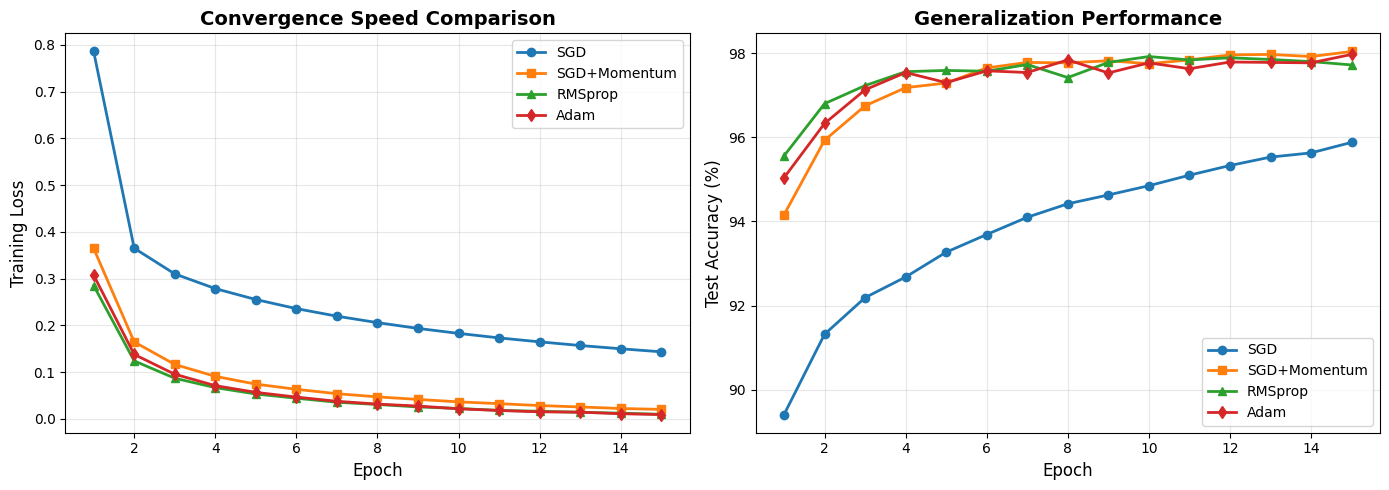

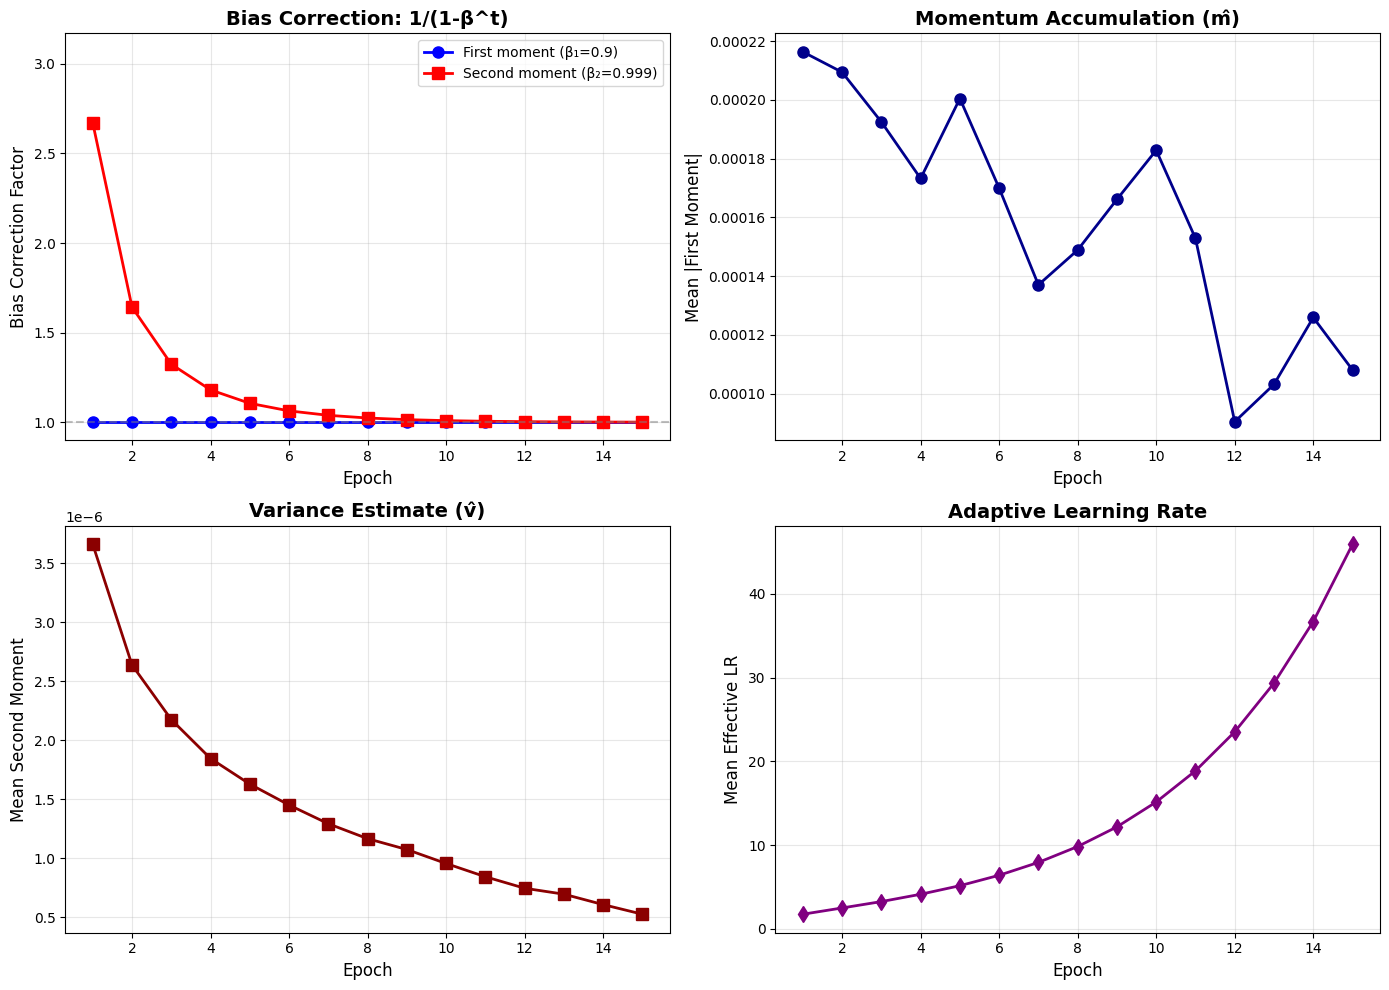

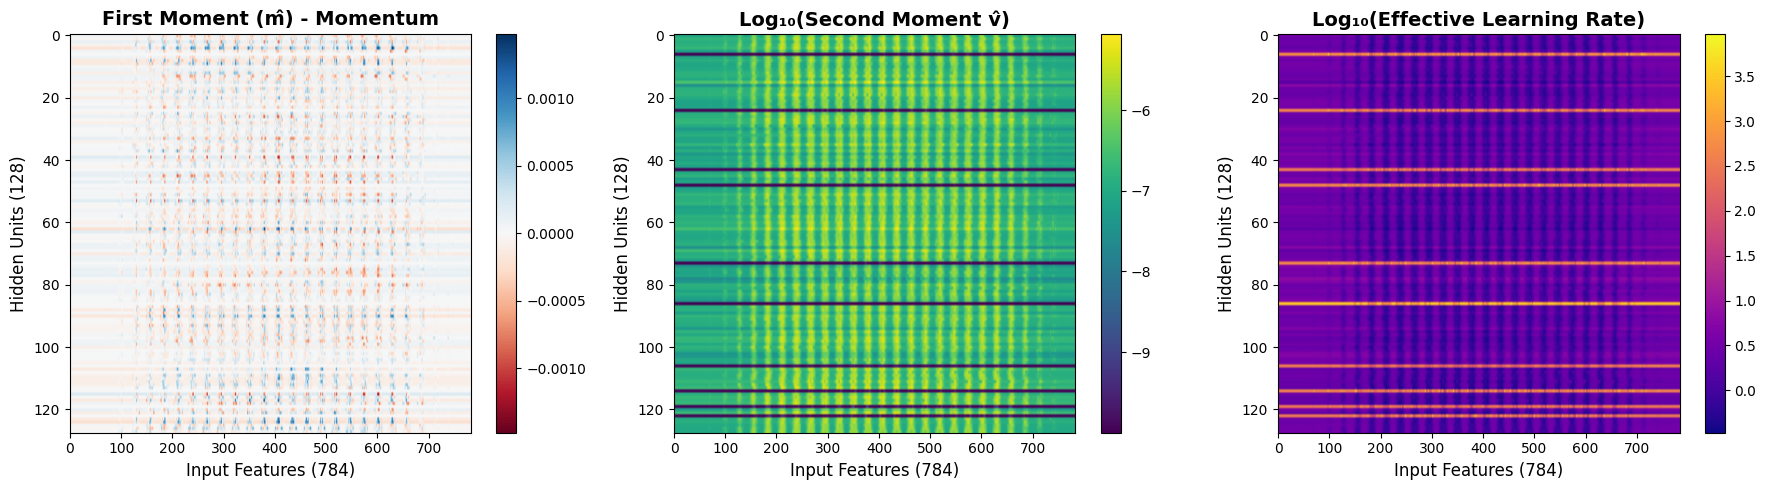


FINAL RESULTS SUMMARY
Method               Final Loss      Final Acc       Best Acc        Time (s)    
------------------------------------------------------------------------------------------
SGD                  0.1433          95.88           95.88           215.34      
SGD+Momentum         0.0201          98.04           98.04           212.21      
RMSprop              0.0096          97.72           97.92           214.93      
Adam                 0.0090          97.97           97.97           215.40      


In [5]:
# Neural network (same architecture)
class SimpleNet(nn.Module):
    """
    Architecture: 784 -> 128 -> 10
    Total parameters: ~101K
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# ## 3. Data Loading and Training Functions


def get_mnist_loaders(batch_size: int = 128) -> Tuple[DataLoader, DataLoader]:
    """Load MNIST dataset with standard normalization"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                optimizer,
                criterion: nn.Module,
                device: str = 'cpu') -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        params = list(model.parameters())
        grads = [p.grad for p in params]
        optimizer.step(params, grads)

        for p in params:
            p.grad.zero_()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model: nn.Module, test_loader: DataLoader, device: str = 'cpu') -> float:
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total


# ## 4. Experiments: Comprehensive Optimiser Comparison
# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15
batch_size = 128

print(f"Device: {device}")
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}")
print("=" * 60)

# Load data
train_loader, test_loader = get_mnist_loaders(batch_size)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


# Experiment 1: Standard SGD
print("\n" + "=" * 60)
print("EXPERIMENT 1: Standard SGD (η=0.01)")
print("=" * 60)

model_sgd = SimpleNet().to(device)
optimizer_sgd = SGDMomentum(lr=0.01, momentum=0.0)
criterion = nn.CrossEntropyLoss()

sgd_losses = []
sgd_accuracies = []
sgd_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_sgd, train_loader, optimizer_sgd, criterion, device)
    acc = evaluate(model_sgd, test_loader, device)
    sgd_losses.append(loss)
    sgd_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

sgd_time = time.time() - sgd_time
print(f"Total training time: {sgd_time:.2f}s")


# Experiment 2: SGD with Momentum
print("\n" + "=" * 60)
print("EXPERIMENT 2: SGD + Momentum (η=0.01, β=0.9)")
print("=" * 60)

model_momentum = SimpleNet().to(device)
optimizer_momentum = SGDMomentum(lr=0.01, momentum=0.9)

momentum_losses = []
momentum_accuracies = []
momentum_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_momentum, train_loader, optimizer_momentum, criterion, device)
    acc = evaluate(model_momentum, test_loader, device)
    momentum_losses.append(loss)
    momentum_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

momentum_time = time.time() - momentum_time
print(f"Total training time: {momentum_time:.2f}s")


# Experiment 3: RMSprop
print("\n" + "=" * 60)
print("EXPERIMENT 3: RMSprop (η=0.001, γ=0.9)")
print("=" * 60)

model_rmsprop = SimpleNet().to(device)
optimizer_rmsprop = RMSprop(lr=0.001, gamma=0.9, eps=1e-8)

rmsprop_losses = []
rmsprop_accuracies = []
rmsprop_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_rmsprop, train_loader, optimizer_rmsprop, criterion, device)
    acc = evaluate(model_rmsprop, test_loader, device)
    rmsprop_losses.append(loss)
    rmsprop_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

rmsprop_time = time.time() - rmsprop_time
print(f"Total training time: {rmsprop_time:.2f}s")


# Experiment 4: Adam
print("\n" + "=" * 60)
print("EXPERIMENT 4: Adam (η=0.001, β₁=0.9, β₂=0.999)")
print("=" * 60)

model_adam = SimpleNet().to(device)
optimizer_adam = Adam(lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8)

adam_losses = []
adam_accuracies = []
adam_moment_stats = []
adam_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_adam, train_loader, optimizer_adam, criterion, device)
    acc = evaluate(model_adam, test_loader, device)
    adam_losses.append(loss)
    adam_accuracies.append(acc)

    # Track moment statistics
    fc1_weight = model_adam.fc1.weight
    first_moment = optimizer_adam.get_first_moment(fc1_weight)
    second_moment = optimizer_adam.get_second_moment(fc1_weight)
    effective_lr = optimizer_adam.get_effective_lr(fc1_weight)

    moment_stats = {
        'm_mean': first_moment.abs().mean().item(),
        'v_mean': second_moment.mean().item(),
        'lr_mean': effective_lr.mean().item(),
        'bias_corr_m': 1 / (1 - optimizer_adam.beta1 ** optimizer_adam.t),
        'bias_corr_v': 1 / (1 - optimizer_adam.beta2 ** optimizer_adam.t)
    }
    adam_moment_stats.append(moment_stats)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}% | "
          f"Avg LR: {moment_stats['lr_mean']:.6f}")

adam_time = time.time() - adam_time
print(f"Total training time: {adam_time:.2f}s")


# ## 5. Visualisation and Analysis
# Plot 1: Comprehensive Optimizer Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
axes[0].plot(range(1, epochs+1), sgd_losses, 'o-', label='SGD', linewidth=2, markersize=6)
axes[0].plot(range(1, epochs+1), momentum_losses, 's-', label='SGD+Momentum', linewidth=2, markersize=6)
axes[0].plot(range(1, epochs+1), rmsprop_losses, '^-', label='RMSprop', linewidth=2, markersize=6)
axes[0].plot(range(1, epochs+1), adam_losses, 'd-', label='Adam', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Convergence Speed Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test Accuracy
axes[1].plot(range(1, epochs+1), sgd_accuracies, 'o-', label='SGD', linewidth=2, markersize=6)
axes[1].plot(range(1, epochs+1), momentum_accuracies, 's-', label='SGD+Momentum', linewidth=2, markersize=6)
axes[1].plot(range(1, epochs+1), rmsprop_accuracies, '^-', label='RMSprop', linewidth=2, markersize=6)
axes[1].plot(range(1, epochs+1), adam_accuracies, 'd-', label='Adam', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1].set_title('Generalization Performance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('day04_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Plot 2: Adam's Moment Estimates and Bias Correction
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bias correction factors over time
bias_corr_m = [stat['bias_corr_m'] for stat in adam_moment_stats]
bias_corr_v = [stat['bias_corr_v'] for stat in adam_moment_stats]

axes[0, 0].plot(range(1, epochs+1), bias_corr_m, 'o-', linewidth=2,
                markersize=8, color='blue', label='First moment (β₁=0.9)')
axes[0, 0].plot(range(1, epochs+1), bias_corr_v, 's-', linewidth=2,
                markersize=8, color='red', label='Second moment (β₂=0.999)')
axes[0, 0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Bias Correction Factor', fontsize=12)
axes[0, 0].set_title('Bias Correction: 1/(1-β^t)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0.9, max(max(bias_corr_m), max(bias_corr_v)) + 0.5])

# First moment (momentum) magnitude
m_means = [stat['m_mean'] for stat in adam_moment_stats]
axes[0, 1].plot(range(1, epochs+1), m_means, 'o-', linewidth=2,
                markersize=8, color='darkblue')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Mean |First Moment|', fontsize=12)
axes[0, 1].set_title('Momentum Accumulation (m̂)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Second moment magnitude
v_means = [stat['v_mean'] for stat in adam_moment_stats]
axes[1, 0].plot(range(1, epochs+1), v_means, 's-', linewidth=2,
                markersize=8, color='darkred')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Mean Second Moment', fontsize=12)
axes[1, 0].set_title('Variance Estimate (v̂)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Effective learning rate
lr_means = [stat['lr_mean'] for stat in adam_moment_stats]
axes[1, 1].plot(range(1, epochs+1), lr_means, 'd-', linewidth=2,
                markersize=8, color='purple')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Mean Effective LR', fontsize=12)
axes[1, 1].set_title('Adaptive Learning Rate', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('day04_adam_moments.png', dpi=300, bbox_inches='tight')
plt.show()


# Plot 3: Heatmap visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# First moment heatmap
fc1_first_moment = optimizer_adam.get_first_moment(model_adam.fc1.weight).cpu().detach().numpy()
im1 = axes[0].imshow(fc1_first_moment, aspect='auto', cmap='RdBu',
                     vmin=-np.abs(fc1_first_moment).max(), vmax=np.abs(fc1_first_moment).max())
axes[0].set_xlabel('Input Features (784)', fontsize=12)
axes[0].set_ylabel('Hidden Units (128)', fontsize=12)
axes[0].set_title('First Moment (m̂) - Momentum', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# Second moment heatmap
fc1_second_moment = optimizer_adam.get_second_moment(model_adam.fc1.weight).cpu().detach().numpy()
im2 = axes[1].imshow(np.log10(fc1_second_moment + 1e-10), aspect='auto', cmap='viridis')
axes[1].set_xlabel('Input Features (784)', fontsize=12)
axes[1].set_ylabel('Hidden Units (128)', fontsize=12)
axes[1].set_title('Log₁₀(Second Moment v̂)', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=axes[1])

# Effective learning rate heatmap
fc1_effective_lr = optimizer_adam.get_effective_lr(model_adam.fc1.weight).cpu().detach().numpy()
im3 = axes[2].imshow(np.log10(fc1_effective_lr), aspect='auto', cmap='plasma')
axes[2].set_xlabel('Input Features (784)', fontsize=12)
axes[2].set_ylabel('Hidden Units (128)', fontsize=12)
axes[2].set_title('Log₁₀(Effective Learning Rate)', fontsize=14, fontweight='bold')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.savefig('day04_adam_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()


# Results summary table
print("\n" + "=" * 90)
print("FINAL RESULTS SUMMARY")
print("=" * 90)

results = {
    'Method': ['SGD', 'SGD+Momentum', 'RMSprop', 'Adam'],
    'Final Loss': [f"{sgd_losses[-1]:.4f}", f"{momentum_losses[-1]:.4f}",
                   f"{rmsprop_losses[-1]:.4f}", f"{adam_losses[-1]:.4f}"],
    'Final Accuracy (%)': [f"{sgd_accuracies[-1]:.2f}", f"{momentum_accuracies[-1]:.2f}",
                           f"{rmsprop_accuracies[-1]:.2f}", f"{adam_accuracies[-1]:.2f}"],
    'Best Accuracy (%)': [f"{max(sgd_accuracies):.2f}", f"{max(momentum_accuracies):.2f}",
                          f"{max(rmsprop_accuracies):.2f}", f"{max(adam_accuracies):.2f}"],
    'Training Time (s)': [f"{sgd_time:.2f}", f"{momentum_time:.2f}",
                          f"{rmsprop_time:.2f}", f"{adam_time:.2f}"]
}

for i in range(len(results['Method'])):
    if i == 0:
        print(f"{'Method':<20} {'Final Loss':<15} {'Final Acc':<15} {'Best Acc':<15} {'Time (s)':<12}")
        print("-" * 90)

    print(f"{results['Method'][i]:<20} {results['Final Loss'][i]:<15} {results['Final Accuracy (%)'][i]:<15} "
          f"{results['Best Accuracy (%)'][i]:<15} {results['Training Time (s)'][i]:<12}")

print("=" * 90)